In [1]:
api_key = '####################'
secret = '####################'

In [2]:
from BTC import get_new_data, get_hist_data,indi_calc,strategy_calc

In [3]:
import pandas as pd
import random
from datetime import datetime
from prophet import Prophet
from binance.futures import Futures as Client
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from fitter import Fitter, get_common_distributions, get_distributions

In [4]:
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
import torchmetrics
from torchmetrics import MetricCollection, Accuracy, Specificity, Precision, Recall, AUROC, F1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from torchsummary import summary

In [7]:
import ta
import arff

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torchvision import datasets, models, transforms
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import optuna

In [9]:
futures_client = Client()

## price data import

In [12]:
collumns2 = [
'Open time',
'Open',
'High',
'Low',
'Close',
'Volume',
'Close time',
'Quote asset volume',
'Number of trades',
'Taker buy base asset volume',
'Taker buy quote asset volume',
'Ignore'
]

In [13]:
def to_df(data_as_array):
    df=pd.DataFrame(data_as_array, columns = collumns2)
    df['Open time'] = df.apply(lambda x: datetime.fromtimestamp(int(x['Open time'])/1000) , axis=1)
    df['Close time'] = df.apply(lambda x: datetime.fromtimestamp(int(x['Close time'])/1000) , axis=1)
    df.drop(columns = ['Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'], inplace = True)
    df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype('float32', copy=False)
    return df

In [14]:
data_1d = futures_client.klines("BTCUSDT", "1d", **{"limit": 1500})

In [36]:
df = to_df(data_1d)

In [37]:
df.head(5)

,Open time,Open,High,Low,Close,Volume
0,2019-09-07 20:00:00,10000.000000,10412.650391,10000.000000,10391.629883,3096.291016
1,2019-09-08 20:00:00,10316.620117,10475.540039,10077.219727,10307.000000,14824.373047
2,2019-09-09 20:00:00,10307.000000,10382.969727,9940.870117,10102.019531,9068.955078
3,2019-09-10 20:00:00,10094.269531,10293.110352,9884.309570,10159.549805,10897.921875
4,2019-09-11 20:00:00,10163.059570,10450.129883,10042.120117,10415.129883,15609.633789


## indicators calculation

In [38]:
df_RSI_ADX = indi_calc(df).RSI_ADX(14,20)
df = df_RSI_ADX

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


## volume change calculation

In [39]:
# multiplicator = 0.2
percent_vol = []
cum_volume_step = 7
i = 0
for v in df.Volume:
    if cum_volume_step > i:
        percent_vol.append(np.nan)
    else:
        percent_vol.append(100*v/df.Volume[i-cum_volume_step:i].sum())
    i+=1
df['Vol_week'] = percent_vol

## present price changing

In [40]:
present_price = []
cum_volume_step = 7
i = 0
for v in df.Open:
    if cum_volume_step > i:
        present_price.append(np.nan)
    else:
        present_price.append((v - df.Open[i-cum_volume_step])/df.Open[i-cum_volume_step])
    i+=1
df['last_week'] = present_price

In [41]:
present_price = []
cum_volume_step = 30
i = 0
for v in df.Open:
    if cum_volume_step > i:
        present_price.append(np.nan)
    else:
        present_price.append((v - df.Open[i-cum_volume_step])/df.Open[i-cum_volume_step])
    i+=1
df['last_month'] = present_price

In [42]:
present_price = []
cum_volume_step = 1
i = 0
for v in df.Open:
    if cum_volume_step > i:
        present_price.append(np.nan)
    else:
        present_price.append((df.Close[i-cum_volume_step] - df.Open[i-cum_volume_step])/df.Open[i-cum_volume_step])
    i+=1
df['yesterday'] = present_price

In [43]:
present_price = []
cum_volume_step = 1
i = 0
for v in df.RSI:
    if i<1:
        present_price.append(np.nan)
    else:
        present_price.append((v - df.RSI[i-cum_volume_step])/df.RSI[i-cum_volume_step])
    i+=1
df['RSI_gap'] = present_price

## future price change

In [44]:
future_price = []
lengh = len(df.Open)
i = 0
for v in range(lengh):
    aver_future_price = (df.Close[i]-df.Open[i])/df.Open[i]
    future_price.append(100*aver_future_price)
    i+=1
df['target'] = future_price

<AxesSubplot:>

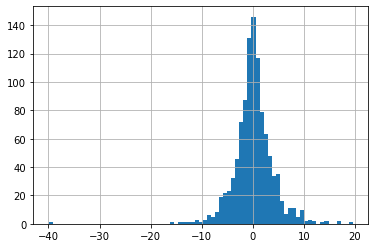

In [45]:
df.target.hist(bins=75)

In [47]:
df = df[['ADX', '-DI', '+DI', 'RSI', 'Vol_week', 'last_week', 'last_month', 'yesterday', 'RSI_gap','target']]

In [49]:
df.head()

,ADX,-DI,+DI,RSI,Vol_week,last_week,last_month,yesterday,RSI_gap,target
0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.916299
1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.039163,NaN,-0.093249
2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,-0.000932,NaN,-1.988750
3,0.0,0.0,0.0,NaN,NaN,NaN,NaN,-0.019888,NaN,0.646706
4,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.006467,NaN,2.480260


In [50]:
#df.to_csv('BTC_daily2.csv', index = False)

In [10]:
#df = pd.read_csv('BTC_daily.csv')

In [52]:
df = df.dropna()

In [53]:
df['target'] = df['target'].apply(lambda x: 1 if x>=0 else 0)

<ipython-input-53-a5fbeb98518e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].apply(lambda x: 1 if x>=0 else 0)


In [57]:
df['target'] = df['target'].astype('category')

<ipython-input-57-2226efc13b9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].astype('category')


# simple NN

In [56]:
def train(dataloader, model, loss, optimizer, t):
    
    model.train()
    size = len(dataloader.dataset)
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        loss += loss.item()
        
    writer.add_scalar('Loss/train', loss, t)
    
def test(dataloader, model,t):
    
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    
    # initialize metric
    test_metric_collection = MetricCollection([
    Accuracy(),
    AUROC(),
    Recall(),
    Precision(),
    F1Score()
    ]).to(device)
    
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            test_loss += criterion(y_test_pred, y_batch.unsqueeze(1)).item()
            y_batch = y_batch.type(torch.int)
            prediction = y_test_pred.T[0]
            test_metric_collection(prediction, y_batch)
    test_loss /= size
    total_metric_collection = test_metric_collection.compute()
    
    writer.add_scalar('Loss/test', test_loss, t)
    writer.add_scalar('Accuracy/test', total_metric_collection['Accuracy'], t)
    writer.add_scalar('AUROC/test', total_metric_collection['AUROC'], t)
    writer.add_scalar('Sensitivity/test', total_metric_collection['Recall'], t)
    writer.add_scalar('Precision/test', total_metric_collection['Precision'], t)
    writer.add_scalar('F1/test', total_metric_collection['F1Score'], t)
    
    test_metric_collection.reset()

In [57]:
df['target'] = df['target'].astype('category')

<ipython-input-57-2226efc13b9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].astype('category')


In [59]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [89]:
lenght_train = int(len(df)*0.7)
lenght_valid = int(len(df)*0.04)
lenght_test = len(df) - lenght_train - lenght_valid

In [90]:
X_train = X[:lenght_train]
X_valid = X[lenght_train : lenght_train + lenght_valid]
X_test = X[-lenght_test:]

In [91]:
y_train = y[:lenght_train]
y_valid = y[lenght_train : lenght_train + lenght_valid]
y_test = y[-lenght_test:]

In [92]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [93]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [94]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train.values))

## train data
class ValidData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


valid_data = ValidData(torch.FloatTensor(X_valid), 
                       torch.FloatTensor(y_valid.values))

## test data    
class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test), 
                     torch.FloatTensor(y_test.values))

In [95]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

## model 1

In [73]:
class BTC_100(nn.Module):
    def __init__(self):
        super(BTC_100, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(9, 16) 
        self.layer_2 = nn.Linear(16, 8)
        self.layer_3 = nn.Linear(8, 4)
        self.layer_out = nn.Linear(4, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(8)
        self.batchnorm3 = nn.BatchNorm1d(4)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [74]:
device = torch.device("cpu")
print(device)

cpu


In [75]:
model = BTC_100()
model.to(device)
criterion = nn.BCEWithLogitsLoss()

epochs = 500

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
writer = SummaryWriter(log_dir = 'runs/' + str(model).split('(')[0])

for t in range(epochs):
    train(train_loader, model, criterion, optimizer, t)
    test(valid_loader, model, t)
    torch.save(model.state_dict(), 'models/' + str(model).split('(')[0] + '_tvt_' + str(t) + '.pt')

writer.close()
torch.cuda.empty_cache()

C:\Users\bakhi\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


recall : 0.7307692307692307
precision : 0.6495726495726496
F1 : 0.6877828054298643
acc : 0.6634146341463415


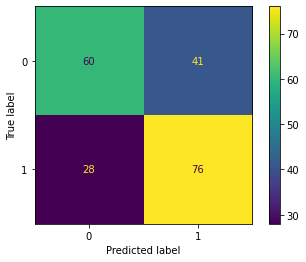

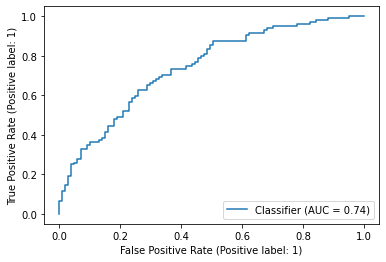

In [77]:
model = BTC_100()
model_name = 'models/' + str(model).split('(')[0] + '_tvt_' + str(495) + '.pt'
state_dict = torch.load(model_name)
model.load_state_dict(state_dict)


y_pred_list_rounded = []
y_pred_list = []
targets = []


model.eval()
with torch.no_grad():
    for X_batch, y_batch in valid_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        targets.append(y_batch)

        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list_rounded.append(y_pred_tag.cpu().numpy())
        y_pred_list.append(y_test_pred.cpu().numpy())

y_pred_list_rounded = [a.squeeze().tolist() for a in y_pred_list_rounded]
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
targets = [a.squeeze().tolist() for a in targets]


y_pred_list_rounded = [j for sub in y_pred_list_rounded for j in sub]
y_pred_list = [j for sub in y_pred_list for j in sub]
targets = [j for sub in targets for j in sub]

cm = confusion_matrix(targets, y_pred_list_rounded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()
TP, FP, TN, FN = cm[1,1], cm[0,1], cm[0,0], cm[1,0]
P = TP/(TP+FP)
R = TP/(TP+FN)
F1 = 2*P*R/(P+R)
print(f'recall : {R}')
print(f'precision : {P}')
print(f'F1 : {F1}')
print(f'acc : {(TP + TN)/(TP + TN + FP + FN)}')
RocCurveDisplay.from_predictions(targets, y_pred_list)

## model 101 reduced valid data set = 100 days

In [85]:
class BTC_101(nn.Module):
    def __init__(self):
        super(BTC_101, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(9, 16) 
        self.layer_2 = nn.Linear(16, 8)
        self.layer_3 = nn.Linear(8, 4)
        self.layer_out = nn.Linear(4, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(8)
        self.batchnorm3 = nn.BatchNorm1d(4)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [86]:
device = torch.device("cpu")
print(device)

cpu


In [87]:
model = BTC_101()
model.to(device)
criterion = nn.BCEWithLogitsLoss()

epochs = 500

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
writer = SummaryWriter(log_dir = 'runs/' + str(model).split('(')[0])

for t in range(epochs):
    train(train_loader, model, criterion, optimizer, t)
    test(valid_loader, model, t)
    torch.save(model.state_dict(), 'models/' + str(model).split('(')[0] + '_tvt_' + str(t) + '.pt')

writer.close()
torch.cuda.empty_cache()

C:\Users\bakhi\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


recall : 0.673469387755102
precision : 0.6875
F1 : 0.6804123711340205
acc : 0.696078431372549


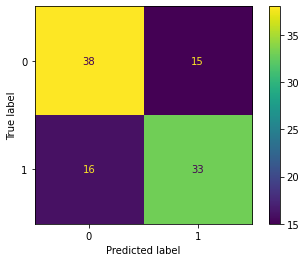

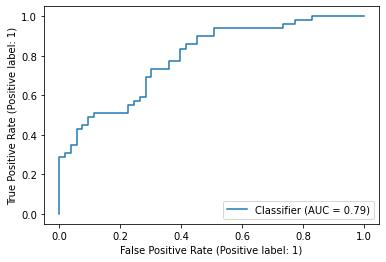

In [88]:
model = BTC_101()
model_name = 'models/' + str(model).split('(')[0] + '_tvt_' + str(495) + '.pt'
state_dict = torch.load(model_name)
model.load_state_dict(state_dict)


y_pred_list_rounded = []
y_pred_list = []
targets = []


model.eval()
with torch.no_grad():
    for X_batch, y_batch in valid_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        targets.append(y_batch)

        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list_rounded.append(y_pred_tag.cpu().numpy())
        y_pred_list.append(y_test_pred.cpu().numpy())

y_pred_list_rounded = [a.squeeze().tolist() for a in y_pred_list_rounded]
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
targets = [a.squeeze().tolist() for a in targets]


y_pred_list_rounded = [j for sub in y_pred_list_rounded for j in sub]
y_pred_list = [j for sub in y_pred_list for j in sub]
targets = [j for sub in targets for j in sub]

cm = confusion_matrix(targets, y_pred_list_rounded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()
TP, FP, TN, FN = cm[1,1], cm[0,1], cm[0,0], cm[1,0]
P = TP/(TP+FP)
R = TP/(TP+FN)
F1 = 2*P*R/(P+R)
print(f'recall : {R}')
print(f'precision : {P}')
print(f'F1 : {F1}')
print(f'acc : {(TP + TN)/(TP + TN + FP + FN)}')
RocCurveDisplay.from_predictions(targets, y_pred_list)

## model 102 reduced valid data set = 30 days

In [96]:
class BTC_102(nn.Module):
    def __init__(self):
        super(BTC_102, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(9, 16) 
        self.layer_2 = nn.Linear(16, 8)
        self.layer_3 = nn.Linear(8, 4)
        self.layer_out = nn.Linear(4, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(8)
        self.batchnorm3 = nn.BatchNorm1d(4)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [97]:
device = torch.device("cpu")
print(device)

cpu


In [98]:
model = BTC_102()
model.to(device)
criterion = nn.BCEWithLogitsLoss()

epochs = 500

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
writer = SummaryWriter(log_dir = 'runs/' + str(model).split('(')[0])

for t in range(epochs):
    train(train_loader, model, criterion, optimizer, t)
    test(valid_loader, model, t)
    torch.save(model.state_dict(), 'models/' + str(model).split('(')[0] + '_tvt_' + str(t) + '.pt')

writer.close()
torch.cuda.empty_cache()

C:\Users\bakhi\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


recall : 0.5
precision : 0.8461538461538461
F1 : 0.6285714285714286
acc : 0.6829268292682927


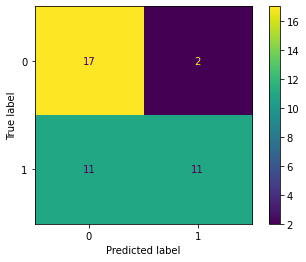

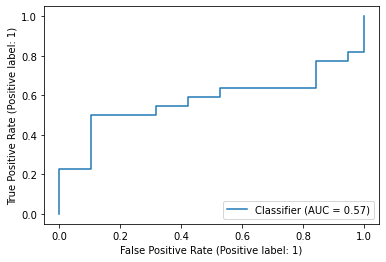

In [99]:
model = BTC_102()
model_name = 'models/' + str(model).split('(')[0] + '_tvt_' + str(495) + '.pt'
state_dict = torch.load(model_name)
model.load_state_dict(state_dict)


y_pred_list_rounded = []
y_pred_list = []
targets = []


model.eval()
with torch.no_grad():
    for X_batch, y_batch in valid_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        targets.append(y_batch)

        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list_rounded.append(y_pred_tag.cpu().numpy())
        y_pred_list.append(y_test_pred.cpu().numpy())

y_pred_list_rounded = [a.squeeze().tolist() for a in y_pred_list_rounded]
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
targets = [a.squeeze().tolist() for a in targets]


y_pred_list_rounded = [j for sub in y_pred_list_rounded for j in sub]
y_pred_list = [j for sub in y_pred_list for j in sub]
targets = [j for sub in targets for j in sub]

cm = confusion_matrix(targets, y_pred_list_rounded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()
TP, FP, TN, FN = cm[1,1], cm[0,1], cm[0,0], cm[1,0]
P = TP/(TP+FP)
R = TP/(TP+FN)
F1 = 2*P*R/(P+R)
print(f'recall : {R}')
print(f'precision : {P}')
print(f'F1 : {F1}')
print(f'acc : {(TP + TN)/(TP + TN + FP + FN)}')
RocCurveDisplay.from_predictions(targets, y_pred_list)